# Memristor

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [4]:
# ----  Standard import
import matplotlib.pyplot as plt
import numpy as np

# ----- Spice import
from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Unit import *

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [5]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Class creation Memristor

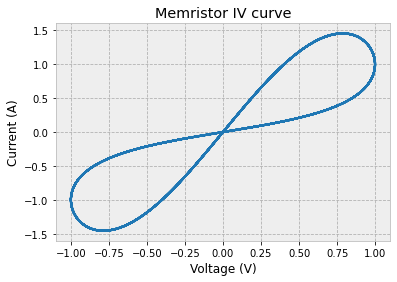

In [44]:
t = np.linspace(0, 100, 1000)
v = np.sin(t)
c1 = 0
i = (np.exp(-np.cos(t)+c1))*np.sin(t)

plt.plot(v, i, label='V-I')
plt.title('Memristor IV curve')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.savefig('linear_memristor.png')
plt.show()

In [45]:
class Memristor(SubCircuit):
    def __init__(self, name, K=0.00005, Kp=0.13*10**-3, C=0.1@u_pF, Vto=0, SwitchRoff=10**20, SwitchRon=10**-3):
        __nodes__ = ('S', 'D', 'phi')
        SubCircuit.__init__(self, name, *__nodes__)
        # self.parameters = {'K': K, 'Kp': Kp, 'C': C, 'Vto': Vto}
        self.VCCS('m', self.gnd, 'o', 'D', 'S', K)
        self.R('R2', 'o', self.gnd, 10**12)
        self.VoltageControlledSwitch('sw', 'o', 'Cmem', 'phi', self.gnd, model='my_switch')
        self.model('my_switch', "SW", Ron=SwitchRon, Roff=SwitchRoff, Vt=0.5)
        self.C('C', self.gnd, 'Cmem', C)
        self.model('my_nmos', 'NMOS', level=3, Vto=Vto, Kp=Kp)
        # M1 drain gate source body
        self.MOSFET(1, 'D', 'Cmem', 'S', self.gnd, model='my_nmos')

In [46]:
class MemristorsInSeries(SubCircuit):
    def __init__(self, name, K=0.00045, Kp=0.13*10**-3, C=0.1@u_pF, Vto=0, N=3):
        __nodes__ = ('S', 'D')
        SubCircuit.__init__(self, name, *__nodes__)
        # self.parameters = {'K': K, 'Kp': Kp, 'C': C, 'Vto': Vto}
        self.subcircuit(Memristor('Mem0', K=K, Kp=Kp, C=C, Vto=Vto))
        self.X('Mem0', 'mem0', 'S', 'o0')
        for i in range(1, N):
            self.subcircuit(Memristor('Mem'+str(i), K=K, Kp=Kp, C=C, Vto=Vto))
            self.X('Mem'+str(i), 'mem'+str(i), 'o'+str(i-1), 'o'+str(i))
        self.subcircuit(Memristor('Mem'+str(N), K=K, Kp=Kp, C=C, Vto=Vto))
        self.X('Mem'+str(N), 'mem'+str(N), 'o'+str(N-1), 'D')

In [48]:
def get_all_nodes_Cmem(circuit):
    # this only works for the first level of subcircuits
    nodes = []
    for subcircuit in circuit.subcircuits:
        for node in subcircuit.nodes:
            if node.name.lower() == 'cmem':
                nodes.append(("X"+subcircuit.name+"."+node.name).lower())
    return nodes

def get_all_nodes_recursive(circuit, currentName):
    nodes = []
    for subcircuit in circuit.subcircuits:
        if currentName == "":
            subcircuitName = "X" + subcircuit.name
        else:
            subcircuitName = currentName + ".X" + subcircuit.name
        for node in subcircuit.nodes:
            if node.name != circuit.gnd:
                nodes.append(subcircuitName + "." + node.name)
        nodes += get_all_nodes_recursive(subcircuit, subcircuitName)
    return nodes

def get_all_cmem_nodes_recursive(circuit):
    all_nodes = get_all_nodes_recursive(circuit, "")
    cmem_nodes = []
    for node in all_nodes:
        if node.lower().find("cmem") != -1:
            cmem_nodes.append(node)
    return cmem_nodes

def add_initial_condition(simulator, circuit):
    kwargDict = {}
    IC = 0
    for n in get_all_cmem_nodes_recursive(circuit):
        kwargDict[n] = IC
    print(kwargDict)
    simulator.initial_condition(**kwargDict)


{'XMem1.Cmem': 0}


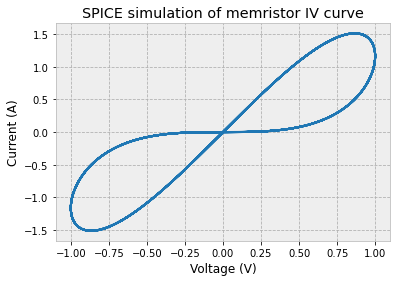

In [50]:
vs = 0
vd = 1
phi = 1.2
circuit = Circuit('NMOS Transistor')
circuit.V('S', 'S', circuit.gnd, vs@u_V)
circuit.SinusoidalVoltageSource('D', 'D', circuit.gnd, amplitude=vd@u_V, frequency=1@u_kHz, offset=0@u_V)
circuit.subcircuit(Memristor('Mem1', K=0.0002, Kp=0.13*10**-3, C=0.1@u_pF, Vto=0))
circuit.V('phi', 'phi', circuit.gnd, phi@u_V)
circuit.X('Mem1', 'mem1', 'S', 'D', 'phi')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
# IMPORTANT! the initial condition is neccesary for capacitor to work
add_initial_condition(simulator, circuit)

analysis = simulator.transient(step_time=0.0001@u_ms, end_time=10@u_ms, use_initial_condition=True)

# vd vs ID
vds = np.array(analysis['D']) - np.array(analysis['S'])
plt.plot(vds, np.array(analysis.branches['vs']))
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title("SPICE simulation of memristor IV curve")
plt.savefig('memristor_circuit_simulation.png')
plt.show()

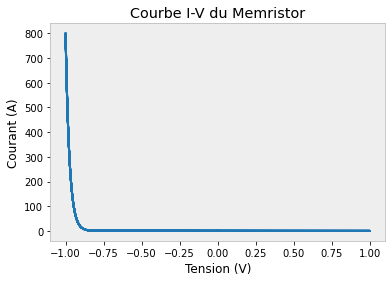

In [24]:
from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Unit import *

# Classe Memristor corrigée
class Memristor(SubCircuit):
    __nodes__ = ('S', 'D')
    
    def __init__(self, name, K, Kp, C, Vto, Roff, Ron):
        SubCircuit.__init__(self, name, *self.__nodes__)
        
        self.VCCS('m', self.gnd, 'o', 'D', 'S', transconductance=K)
        self.R('R2', 'o', self.gnd, 10**12 @ u_Ω)
        
        self.VoltageControlledSwitch(
            'sw', 'o', 'Cmem', 'phi', self.gnd, 
            model="switch"
        )
        self.model("switch", "SW", Ron=Ron, Roff=Roff, Vt=0.5)
        
        self.C('C', self.gnd, 'Cmem', C)
        self.model('memristor_nmos', 'NMOS', level=3, Vto=Vto, Kp=Kp)
        self.MOSFET(1, 'D', 'Cmem', 'S', self.gnd, model='memristor_nmos')

# Circuit
circuit = Circuit("Memristor IV")

# Source sinusoïdale
f = 2  # Hz
V_offset = 0  # V
V_amplitude = 1  # V
delay = 0  # s

circuit.SinusoidalVoltageSource(
    'in', 'vin', circuit.gnd,
    offset=V_offset @ u_V,
    amplitude=V_amplitude @ u_V,
    frequency=f @ u_Hz,
    delay=delay @ u_s
)

# Valeurs des paramètres du memristor (d'après l'article)
K = 2e-4
Kp = 1.3e-4
C = 1e-6  # 1 µF (valeur typique)
Vto = 0.5
Roff = 1e6
Ron = 100

# Enregistrement du sous-circuit
circuit.subcircuit(Memristor(
    'memristor', 
    K=K, Kp=Kp, C=C @ u_F, 
    Vto=Vto, Roff=Roff @ u_Ω, Ron=Ron @ u_Ω
))

# Instanciation du memristor
circuit.X('1', 'memristor', 'vin', circuit.gnd)

# Simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_ms, end_time=2@u_s)

# Affichage
import matplotlib.pyplot as plt
plt.plot(analysis['vin'], analysis.branches["vin"])
plt.xlabel('Tension (V)')
plt.ylabel('Courant (A)')
plt.title('Courbe I-V du Memristor')
plt.grid()
plt.show()

In [18]:
analysis.branches["vin"]

WaveForm vin [ 0.00000000e+00 -1.74574229e-16 -1.89098218e-16 ...  2.45801702e-14
  4.81397754e-15 -2.31051620e-25]@A

In [26]:
from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

############################################
# Sous-circuit Memristor (modèle HP simple)
############################################

class Memristor(SubCircuit):
    __nodes__ = ('p', 'n')

    def __init__(self, name, K, C, Ron, Roff):
        super().__init__(name, *self.__nodes__)

        # Variable d'état interne phi (0 <= phi <= 1)
        # dphi/dt = K * V(p,n)
        self.C('phi', 'phi', self.gnd, C)
        self.VCCS('phi', 'phi', self.gnd, 'p', 'n', K)

        # Résistance dépendante de l'état
        self.BehavioralResistor(
            'mem', 'p', 'n',
            resistance='Ron*limit(V(phi),0,1) + Roff*(1-limit(V(phi),0,1))'
        )


############################################
# Circuit principal
############################################

circuit = Circuit("Memristor I-V")

# Source sinusoïdale
f = 2        # Hz
V_amp = 1    # V

circuit.SinusoidalVoltageSource(
    'in', 'vin', circuit.gnd,
    amplitude=V_amp @ u_V,
    frequency=f @ u_Hz
)

# Paramètres du memristor
K = 2e-4                 # constante de mobilité
C = 1e-6 @ u_F           # capacité d'état
Ron = 100 @ u_Ohm
Roff = 1e6 @ u_Ohm

# Enregistrement du sous-circuit
circuit.subcircuit(
    Memristor(
        'memristor',
        K=K,
        C=C,
        Ron=Ron,
        Roff=Roff
    )
)

# Instanciation
circuit.X('M1', 'memristor', 'vin', circuit.gnd)

############################################
# Simulation transitoire
############################################

simulator = circuit.simulator(
    temperature=25,
    nominal_temperature=25
)

analysis = simulator.transient(
    step_time=1 @ u_ms,
    end_time=2 @ u_s
)

############################################
# Tracé I–V
############################################

# Tension
v = np.array(analysis['vin'])

# Courant dans la source (donc dans le memristor)
i = -np.array(analysis.branches['vin'])

plt.figure(figsize=(6, 5))
plt.plot(v, i)
plt.xlabel("Tension (V)")
plt.ylabel("Courant (A)")
plt.title("Boucle I–V du memristor")
plt.grid(True)
plt.show()

ValueError: Unknown argument resistance=Ron*limit(V(phi),0,1) + Roff*(1-limit(V(phi),0,1))